# Группа DE_622, Студент: Виталий Зайцев

# Курс "Построение хранилища данных и основы ETL"

# Курсовая работа

Реализовать etl систему для загрузки data vault

---

# Подход к выполнению домашнего задания

1. Общая схема
2. Понимание Data Vault модели (__внимание!!!__ получилось сделать только для __двух__ таблиц region и nation)
3. Создание-наполнение таблиц: 
* dds скрипты создания таблиц
* наполнение таблиц данными
4. Изменения в коде модулей папки operators (+ модуль layers.py с поддержкой sae, sal, dds)
5. Сам DAG 

---

# 1. Общая схема

## 1.1. Потоки

* __src__: источник
* __sae__: Данные из source таблицы мигрируем в промежуточный (staging) слой sae
* __sal__: добавлем новый слой al (очистка данных, приведение типов). В нашем случае sal большей частью повторяет sae (дополнительно проверяем наличие ключа)
* __dds__: таблицы целевой data vault модели
* __logstats__: логи и статистика

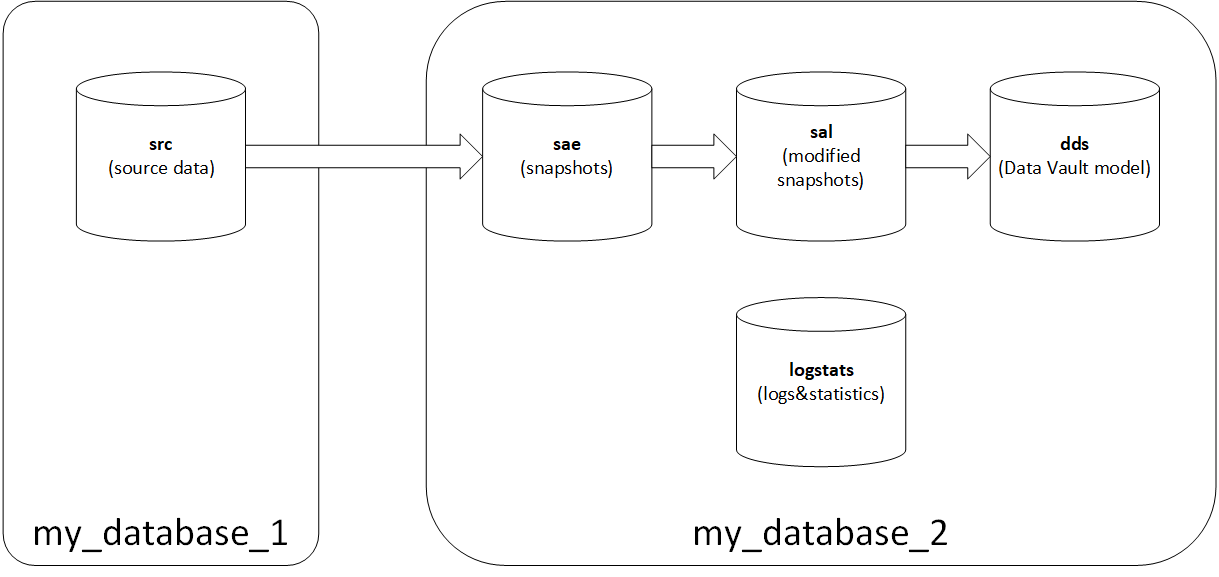

## 1.2. Подготовка докер-образа (docker-compose.yml)

`
version: "3"
services:
  db1:
    image: "postgres:11"
    container_name: "my_postgres_1"
    ports:
      - "5433:5432"
    volumes:
      - my_dbdata_1:/var/lib/postgresql/data1
    environment:
      - POSTGRES_PASSWORD=postgres
      - POSTGRES_USER=root
  db2:
    image: "postgres:11"
    container_name: "my_postgres_2"
    ports:
      - "5470:5432"
    volumes:
      - my_dbdata_2:/var/lib/postgresql/data2
    environment:
      - POSTGRES_PASSWORD=postgres
      - POSTGRES_USER=root
  airflow:
    image: puckel/docker-airflow
    container_name: "airflow"
    ports:
      - "8080:8080"
    environment:
      - PYTHONPATH=/usr/local/airflow/dags/operators/
    volumes:
      - ./dags:/usr/local/airflow/dags
    command: webserver
volumes:
  my_dbdata_1:
  my_dbdata_2:
`

## 1.3. Запуск докер образа

* copypast docker-compose.yml в папку папку размещения airflow /usr/local/airflow/   

* переход в папку размещения airflow /usr/local/airflow/ (в моём случае Win10 и папка ниже)   
`
cd C:\Users\vzaitsev\airflow
`

* запуск докера   
`
docker-compose up -d
`

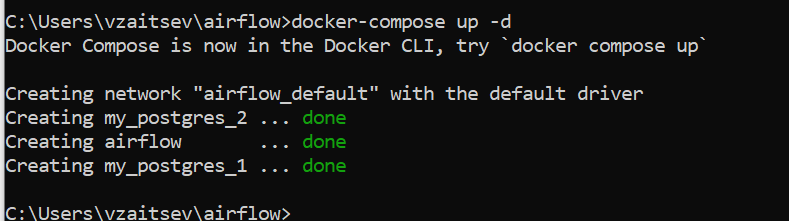

## 1.4. Создание таблиц базы данных источника, наполнение данными

* создание my_database_1 (база-source)   
`
docker exec -it my_postgres_1 psql -U root -c "create database my_database_1"
`   
* создание source таблиц в ETL_course_sourcedatabase и наполнение данными   
`cd C:\DB scripts
docker cp ./01_src.sql my_postgres_1:/
docker exec -it my_postgres_1 psql my_database_1 -f 01_src.sql
`   

* Ранее нагенерённые данные   
`
customer.tbl    
lineitem.tbl   
nation.tbl   
orders.tbl   
part.tbl   
partsupp.tbl   
region.tbl   
supplier.tbl   
`

* копирование данных для таблиц в контейнер   
`
cd C:\Generated tables
docker cp ./customer.tbl my_postgres_1:/
docker cp ./lineitem.tbl my_postgres_1:/
docker cp ./nation.tbl my_postgres_1:/
docker cp ./orders.tbl my_postgres_1:/
docker cp ./part.tbl my_postgres_1:/
docker cp ./partsupp.tbl my_postgres_1:/
docker cp ./region.tbl my_postgres_1:/
docker cp ./supplier.tbl my_postgres_1:/
`
* загрузка данных в базу-source   
`
docker exec -it my_postgres_1 psql my_database_1 -c "\copy src.customer FROM '/customer.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy src.lineitem FROM '/lineitem.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy src.nation FROM '/nation.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy src.orders FROM '/orders.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy src.part FROM '/part.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy src.partsupp FROM '/partsupp.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy src.region FROM '/region.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy src.supplier FROM '/supplier.tbl' CSV DELIMITER '|'"
`

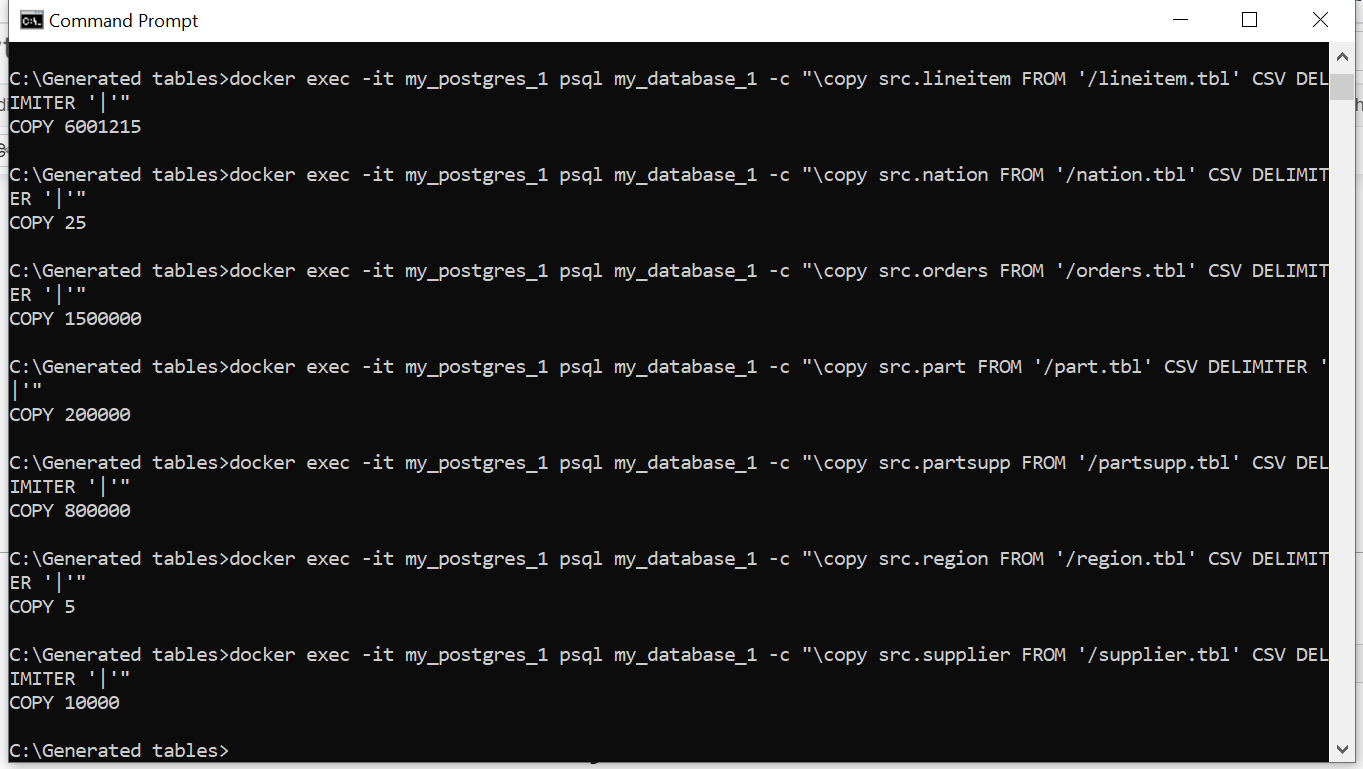

## 1.5. Создание таблиц базы данных приёмника

`
docker exec -it my_postgres_2 psql -U root -c "create database my_database_2"
cd C:\DB scripts
docker cp ./02_sae.sql my_postgres_2:/
docker exec -it my_postgres_2 psql my_database_2 -f 02_sae.sql
docker cp ./03_sal.sql my_postgres_2:/
docker exec -it my_postgres_2 psql my_database_2 -f 03_sal.sql
docker cp ./04_dds.sql my_postgres_2:/
docker exec -it my_postgres_2 psql my_database_2 -f 04_dds.sql
docker cp ./05_logstats.sql my_postgres_2:/
docker exec -it my_postgres_2 psql my_database_2 -f 05_logstats.sql
`

Схемы с таблицами созданы, таблицы-источник наполнены данными
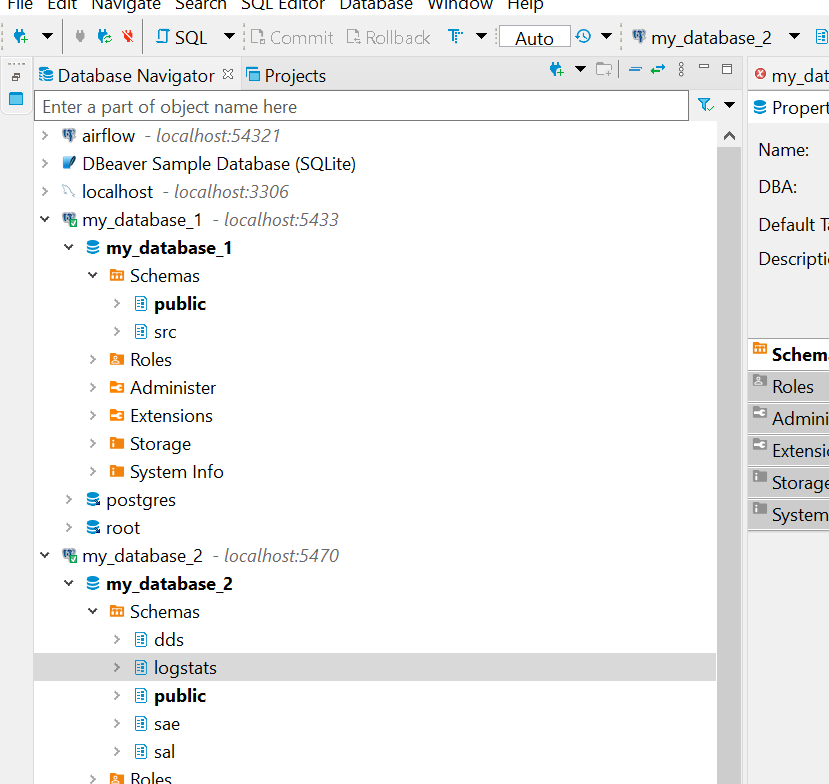

## 1.6. Проверка доступности Airflow http://localhost:8080/admin/
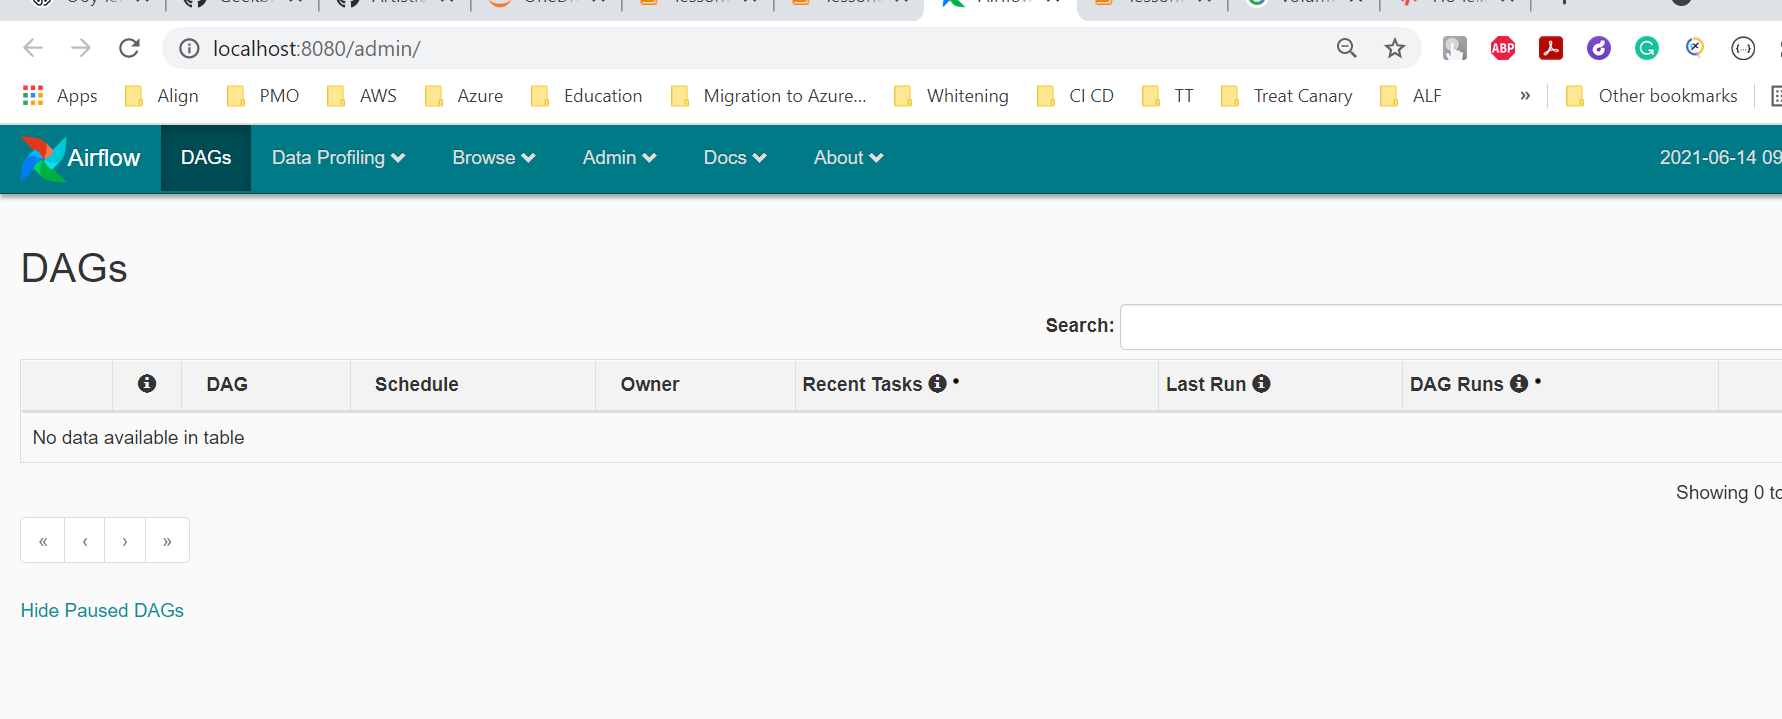

---

# 2. Data Vault модель (только таблицы nation и region)

## 2.1. Общая схема потоков Data Vault модели (только таблицы nation и region)   
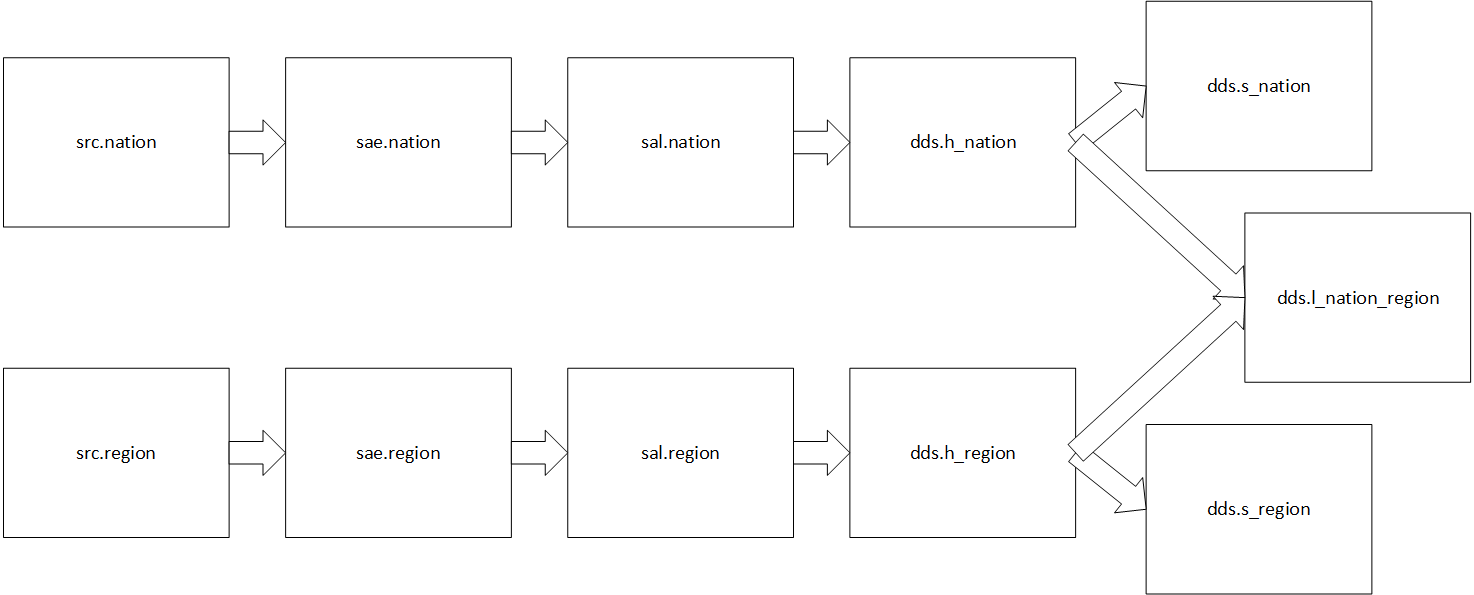

## 2.2. Конфигурирование схемы данных (schema_nation_region.yaml)

In [ ]:
groups:
  hubs:
    nation:
    region:
  links:
    nation_region:
        nation: ['nation', 'region']           
  satellites:
    nation: nation
    region: region
sources:
  tables:
    nation:  
      columns:
      - nation_bk:
          bk_for: nation
      - name:
          source_for: nation
      - region_bk:
          bk_for: region
      - comment:
          source_for: nation        
    region:
      columns:
      - region_bk:
          bk_for: region
      - name:
          source_for: region
      - comment:
          source_for: region


## 2.3. Модуль operators/data_transfer.py

In [ ]:
import datetime
import logging
import os
import time
from contextlib import contextmanager

import psycopg2
from airflow.models import BaseOperator
from airflow.utils.decorators import apply_defaults

from operators.utils import DataFlowBaseOperator


class DataTransfer(DataFlowBaseOperator):  # modify
    @apply_defaults
    def __init__(self, config, target_pg_conn_str,  date_check=True, *args, **kwargs):
        super(DataTransfer, self).__init__(
            *args,
            **kwargs
        )
        self.config = config
        self.target_pg_conn_str = target_pg_conn_str
        self.date_check = date_check

    def provide_data(self, csv_file, context):
        pass

    def execute(self, context):
        copy_statement = """
        COPY {target_schema}.{target_table} ({columns}, launch_id) FROM STDIN with
        DELIMITER '\t'
        CSV
        ESCAPE '\\'
        NULL '';
        """
        schema_name = "{table}".format(**self.config).split(".")
        self.config.update(
            target_schema=schema_name[0],
            target_table=schema_name[1],
            job_id=context["task_instance"].job_id,  # modify
            dt=context["task_instance"].execution_date,  # modify
        )
        # modify
        if self.date_check and context["execution_date"] in self.get_load_dates(
            self.config
        ):
            logging.info("Data already load")
            return
        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
            start = time.time()  # modify
            # modify
            cursor.execute(
                """
            set search_path to logstats; 
            select column_name
              from information_schema.columns
             where table_schema = '{target_schema}'
               and table_name = '{target_table}'
               and column_name not in ('launch_id', 'effective_dttm');
            """.format(
                    **self.config
                )
            )
            result = cursor.fetchall()
            columns = ", ".join('"{}"'.format(row) for row, in result)
            self.config.update(columns=columns)

            with open("./dags/transfer.csv", "w", encoding="utf-8") as csv_file:
                self.provide_data(csv_file, context)

            self.log.info("writing succed")

            with open('./dags/transfer.csv', 'r', encoding="utf-8") as f:
                cursor.copy_expert(copy_statement.format(**self.config), f)

            self.config.update(  # modify
                launch_id=-1,
                duration=datetime.timedelta(seconds=time.time() - start),
                row_count=cursor.rowcount
            )
            self.write_etl_log(self.config)  # modify


## 2.4. Модуль operators/layers.py

In [ ]:
import datetime
import json
import logging
import time

import psycopg2
from airflow.utils.decorators import apply_defaults

from operators.utils import DataFlowBaseOperator


class SalOperator(DataFlowBaseOperator):  # sae -> sal
    defaults = {
        'target_schema': 'sal',
        'source_schema': 'sae',
    }

    @apply_defaults
    def __init__(self, config, target_pg_conn_str, query=None, *args, **kwargs):
        super(SalOperator, self).__init__(
            config=config,
            target_pg_conn_str=target_pg_conn_str,
            *args,
            **kwargs
        )
        self.target_pg_conn_str = target_pg_conn_str
        self.config = dict(self.defaults, **config)
        self.query = query

    def execute(self, context):
        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))

            for launch_id in ids:
                start = time.time()
                self.config.update(
                    launch_id=launch_id,
                )

                cols_sql = """
                select column_name
                     , data_type
                  from information_schema.columns
                 where table_schema = '{target_schema}'
                   and table_name = '{target_table}'
                   and column_name not in ('launch_id', 'effective_dttm');
                """.format(**self.config)

                cursor.execute(cols_sql)
                cols_list = list(cursor.fetchall())
                cols_dtypes = ",\n".join(
                    ('{}::{}'.format(col[0], col[1]) for col in cols_list))
                cols = ",\n".join(col[0] for col in cols_list)
                if self.query:
                    transfer_sql = """
                    with x as ({query})
                    insert into {target_schema}.{target_table} (launch_id, {cols})
                    select {job_id}::int as launch_id,\n{cols_dtypes}\n from x
                    """.format(query=self.query, cols_dtypes=cols_dtypes, cols=cols, **self.config)
                else:
                    transfer_sql = """
                    insert into {target_schema}.{target_table} (launch_id, {cols})
                    select {job_id}::int as launch_id,\n{cols_dtypes}\n from {source_schema}.{source_table}
                    """.format(cols_dtypes=cols_dtypes, cols=cols, **self.config)
                self.log.info('Executing query: {}'.format(transfer_sql))
                cursor.execute(transfer_sql)

                self.config.update(
                    source_schema='{source_schema}'.format(**self.config),
                    duration=datetime.timedelta(seconds=time.time() - start),
                    row_count=cursor.rowcount
                )
                self.log.info(
                    'Inserted rows: {row_count}'.format(**self.config))
                self.write_etl_log(self.config)


class DdsHOperator(DataFlowBaseOperator):  # sal -> dds for hubs
    defaults = {
        'target_schema': 'dds',
        'source_schema': 'sal',
    }

    @apply_defaults
    def __init__(self, config, target_pg_conn_str, *args, **kwargs):
        self.config = dict(
            self.defaults,
            target_table='h_{hub_name}'.format(**config),
            hub_bk='{hub_name}_bk'.format(**config),
            **config
        )
        super(DdsHOperator, self).__init__(
            config=config,
            target_pg_conn_str=target_pg_conn_str,
            *args,
            **kwargs
        )
        self.target_pg_conn_str = target_pg_conn_str

    def execute(self, context):
        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:

            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))

            for launch_id in ids:
                start = time.time()

                self.config.update(
                    launch_id=launch_id
                )

                insert_sql = '''
                with x as (
                    select {bk_column}, {job_id} from {source_schema}.{source_table}
                    where {bk_column} is not null and launch_id = {launch_id}
                    group by 1
                )
                insert into {target_schema}.{target_table} ({hub_bk}, launch_id)
                select * from x;
                '''.format(**self.config)

                self.log.info('Executing query: {}'.format(insert_sql))
                cursor.execute(insert_sql)

                self.config.update(
                    row_count=cursor.rowcount
                )
                self.log.info('Row count: {row_count}'.format(**self.config))
                self.config.update(
                    duration=datetime.timedelta(seconds=time.time() - start)
                )
                self.write_etl_log(self.config)


class DdsLOperator(DataFlowBaseOperator):  # sal -> dds for links
    defaults = {
        'target_schema': 'dds',
        'source_schema': 'sal',
    }

    @apply_defaults
    def __init__(self, config, target_pg_conn_str, *args, **kwargs):
        super(DdsLOperator, self).__init__(
            config=config,
            target_pg_conn_str=target_pg_conn_str,
            *args,
            **kwargs
        )
        self.config = dict(
            self.defaults,
            target_table='l_{link_name}'.format(**config),
            **config
        )
        self.target_pg_conn_str = target_pg_conn_str

    def execute(self, context):
        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))
            hubs = ('{hubs}'.format(**self.config))
            hubs = hubs.replace("'", "").strip('[]').split(', ')
            for launch_id in ids:
                start = time.time()
                self.config.update(
                    launch_id=launch_id,
                )

                the_columns_list = []

                a = 'select distinct * from {source_schema}.{source_table} s \n'.format(
                    **self.config)
                for hub_name in hubs:
                    b = 'JOIN {target_schema}.h_{hub_name} \nON {target_schema}.h_{hub_name}.{hub_name}_bk = s.{hub_name}_bk \n'.format(
                        **self.config, hub_name=hub_name)
                    the_columns_list.append(f'h_{hub_name}_rk')
                    a = a + b
                a = a + 'WHERE s.launch_id = {launch_id}'.format(**self.config)
                str_column_list = str(the_columns_list).strip(
                    "[]").replace("'", "")
                c = f'WITH x AS ({a})\n'
                d = 'INSERT INTO {target_schema}.l_{link_name} ({str_column_list}, launch_id)\nSELECT {str_column_list}, {job_id} FROM x\n'.format(
                    **self.config, str_column_list=str_column_list)
                insert_query = c + d

                # insert_sql = '''
                # with x as (
                #     select distinct
                #            {l_hub_name}_id
                #          , {r_hub_name}_id
                #       from {source_schema}.{source_table} s
                #       join dds.h_{l_hub_name} l
                #       on s.{l_bk_column} = l.{l_hub_name}_id
                #       join dds.h_{r_hub_name} r
                #       on s.h_{r_bk_column} = r.{r_hub_name}_id
                #       where s.launch_id = {launch_id}
                # )
                # insert into {target_schema}.{target_table} ({l_hub_name}_id, {l_hub_name}_id, launch_id)
                # select {l_hub_name}_id
                #      , {r_hub_name}_id
                #      , {job_id}
                #   from x;
                # '''.format(**self.config)

                self.log.info('Executing query: {}'.format(insert_query))
                cursor.execute(insert_query)
                self.config.update(
                    row_count=cursor.rowcount,
                    duration=datetime.timedelta(seconds=time.time() - start)
                )
                self.log.info('Row count: {row_count}'.format(**self.config))
                self.write_etl_log(self.config)


class DdsHSOperator(DataFlowBaseOperator):  # sal -> dds for hub_satellites
    defaults = {
        'target_schema': 'dds',
        'source_schema': 'sal',
    }

    @apply_defaults
    def __init__(self, config, target_pg_conn_str, *args, **kwargs):
        super(DdsHSOperator, self).__init__(
            config=config,
            target_pg_conn_str=target_pg_conn_str,
            *args,
            **kwargs
        )
        self.config = dict(
            self.defaults,
            target_table='s_{hub_name}'.format(**config),
            **config
        )
        self.target_pg_conn_str = target_pg_conn_str

    def execute(self, context):
        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))

            columns_info = '{columns_info}'.format(**self.config)
            columns_info = json.loads(columns_info.replace("'", '"'))
            self.log.info(f'columns info: {columns_info}')
            bk_list = []
            column_list = []
            self.log.info(f'columns list: {column_list}')
            for item in columns_info:
                for column_name, column_data in dict(item).items():
                    if column_data.get('bk_for') == '{hub_name}'.format(**self.config):
                        bk_list.append(column_name)
                    elif column_data.get('source_for') == '{hub_name}'.format(**self.config):
                        column_list.append(column_name)

            str_column_list = str(column_list).strip(
                "[]").replace("'", "")

            for launch_id in ids:
                start = time.time()
                self.config.update(
                    launch_id=launch_id,
                )

                insert_query = '''
                with x as (
                select distinct * from {source_schema}.{source_table} s 
                join {target_schema}.h_{hub_name} 
                on {target_schema}.h_{hub_name}.{hub_name}_bk = s.{hub_name}_bk
                where s.launch_id = {launch_id}
                )
                insert into {target_schema}.{target_table} (h_{hub_name}_rk, {str_column_list}, launch_id)
                select h_{hub_name}_rk, {str_column_list}, {job_id} from x;
                '''.format(**self.config, str_column_list=str_column_list)

                self.log.info('Executing query: {}'.format(insert_query))
                cursor.execute(insert_query)
                self.config.update(
                    row_count=cursor.rowcount,
                    duration=datetime.timedelta(seconds=time.time() - start)
                )
                self.log.info('Row count: {row_count}'.format(**self.config))
                self.write_etl_log(self.config)


class DdsLSOperator(DataFlowBaseOperator):  # sal -> dds for link_satellites
    defaults = {
        'target_schema': 'dds',
        'source_schema': 'sal',
    }

    @apply_defaults
    def __init__(self, config, target_pg_conn_str, *args, **kwargs):
        super(DdsLSOperator, self).__init__(
            config=config,
            target_pg_conn_str=target_pg_conn_str,
            *args,
            **kwargs
        )
        self.config = dict(
            self.defaults,
            target_table='s_l_{link_name}'.format(**config),
            **config
        )
        self.target_pg_conn_str = target_pg_conn_str

    def execute(self, context):
        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))

            columns_info = '{columns_info}'.format(**self.config)
            columns_info = json.loads(columns_info.replace("'", '"'))
            self.log.info(f'columns info: {columns_info}')
            hubs = '{link_name}'.format(**self.config).split("_")
            bk_list = []
            column_list = []

            self.log.info('link name: {link_name}'.format(**self.config))
            for hub_name in hubs:
                self.log.info(f'hub name: {hub_name}')
                for item in columns_info:
                    self.log.info(f'item name: {item}')
                    for column_name, column_data in item.items():
                        self.log.info(f'column name: {column_name}')
                        self.log.info(f'column_data: {column_data}')
                        if column_data.get('bk_for') == f'{hub_name}':
                            bk_list.append(column_name)
                        elif column_data.get('source_for') == '{link_name}'.format(**self.config):
                            column_list.append(column_name)

            self.log.info(f'columns list: {column_list}')

            for launch_id in ids:
                start = time.time()
                self.config.update(
                    launch_id=launch_id,
                )
                bk_list = set(bk_list)
                column_list = set(column_list)
                str_column_list = str(column_list).strip(
                    "{}").replace("'", "")

                insert_query = 'select distinct * from {source_schema}.{source_table} s \n'.format(
                    **self.config)
                for hub_name in hubs:
                    hub_join = 'JOIN {target_schema}.h_{hub_name} \nON {target_schema}.h_{hub_name}.{hub_name}_bk = s.{hub_name}_bk \n'.format(
                        **self.config, hub_name=hub_name)
                    insert_query = insert_query + hub_join
                insert_query = insert_query + \
                    'JOIN {target_schema}.l_{link_name}\nON '.format(
                        **self.config)
                for hub_name in hubs:
                    if hub_name != hubs[-1]:
                        link_join = '{target_schema}.l_{link_name}.h_{hub_name}_rk = {target_schema}.h_{hub_name}.h_{hub_name}_rk AND '.format(
                            **self.config, hub_name=hub_name)
                        insert_query = insert_query + link_join
                    else:
                        link_join = '{target_schema}.l_{link_name}.h_{hub_name}_rk = {target_schema}.h_{hub_name}.h_{hub_name}_rk\n'.format(
                            **self.config, hub_name=hub_name)
                        insert_query = insert_query + link_join
                insert_query = insert_query + \
                    'WHERE s.launch_id = {launch_id}\n'.format(**self.config)
                insert_query = f'WITH x AS (\n{insert_query})\n'
                insert_query = insert_query + 'INSERT INTO {target_schema}.l_s_{link_name} (l_{link_name}_rk, {str_column_list}, launch_id)\nSELECT l_{link_name}_rk, {str_column_list}, {job_id} FROM x\n'.format(
                    **self.config, str_column_list=str_column_list)

                self.log.info('Executing query: {}'.format(insert_query))
                cursor.execute(insert_query)
                self.config.update(
                    row_count=cursor.rowcount,
                    duration=datetime.timedelta(seconds=time.time() - start)
                )
                self.log.info('Row count: {row_count}'.format(**self.config))
                self.write_etl_log(self.config)


## 2.5. Модуль operators/postgres.py

In [ ]:
import csv

import psycopg2

from operators.data_transfer import DataTransfer


class DataTransferPostgres(DataTransfer):
    def __init__(
        self, source_pg_conn_str, query, *args, **kwargs
    ):
        super(DataTransferPostgres, self).__init__(
            source_pg_conn_str=source_pg_conn_str, query=query, *args, **kwargs
        )
        self.source_pg_conn_str = source_pg_conn_str
        self.query = query

    def provide_data(self, csv_file, context):
        pg_conn = psycopg2.connect(self.source_pg_conn_str)
        pg_cursor = pg_conn.cursor()
        query_to_execute = self.query
        self.log.info("Connection string: {}".format(self.source_pg_conn_str))
        self.log.info("Executing query: {}".format(query_to_execute))
        pg_cursor.execute(query_to_execute)
        csvwriter = csv.writer(
            csv_file,
            delimiter="\t",
            quoting=csv.QUOTE_NONE,
            lineterminator="\n",
            escapechar='\\'
        )

        job_id = context["task_instance"].job_id,
        while True:
            rows = pg_cursor.fetchmany(size=1000)
            if rows:
                for row in rows:
                    _row = list(row)
                    _row.append(job_id[0])
                    csvwriter.writerow(_row)
            else:
                break
        pg_conn.close()


## 2.6. Модуль operators/statistics.py

In [ ]:
import logging
import os
import time
import re

import psycopg2
from airflow.utils.decorators import apply_defaults

from operators.data_transfer import DataTransfer


class WriteStatisticsOperator(DataTransfer):
    @apply_defaults
    def __init__(self, config, target_pg_conn_str, *args, **kwargs):
        super(DataTransfer, self).__init__(
            *args,
            **kwargs
        )
        self.config = config
        self.target_pg_conn_str = target_pg_conn_str

    def execute(self, context):

        schema_name = "{table}".format(**self.config).split(".")
        self.config.update(
            target_schema=schema_name[0],
            target_table=schema_name[1],
            job_id=context["task_instance"].job_id,  # modify
            dt=context["task_instance"].execution_date,  # modify
        )

        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
            cursor.execute(
                """
            set search_path to {target_schema};
            select column_name
              from information_schema.columns
             where table_schema = '{target_schema}'
               and table_name = '{target_table}'
               and column_name not in ('launch_id', 'effective_dttm');
            """.format(
                    **self.config
                )
            )
            result = cursor.fetchall()
            columns = ", ".join('"{}"'.format(row) for row, in result)
            self.config.update(columns=columns)
            column_list = list(columns.split(', '))
            for item in column_list:

                self.config.update(column=item)
                with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
                    cursor.execute(
                        """
                        set search_path to {target_schema};
                        select count({column}) from {target_table} where {column} is not null
                        """.format(
                            **self.config)
                    )
                    result = cursor.fetchone()
                    result = re.search(r'\d+', str(result))
                    self.config.update(cnt_all=result[0])
                with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
                    cursor.execute(
                        """ 
                        set search_path to {target_schema};
                        select count({column}) from {target_table} where {column} is null;
                        """.format(
                            **self.config)
                    )
                    result = cursor.fetchone()
                    result = re.search(r'\d+', str(result))
                    self.config.update(cnt_nulls=result[0])

                self.write_etl_statistic(self.config)


## 2.7. Модуль operators/utils.py

In [ ]:
import logging

import psycopg2
from airflow.models import BaseOperator


class DataFlowBaseOperator(BaseOperator):
    def __init__(self, pg_meta_conn_str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pg_meta_conn_str = pg_meta_conn_str

    def write_etl_log(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            set search_path to logstats;
            insert into log (
                   source_launch_id
                 , target_schema
                 , target_table
                 , target_launch_id
                 , row_count
                 , duration
                 , load_date
            )
            select {launch_id}
                , '{target_schema}'
                , '{target_table}'
                , {job_id}
                , {row_count}
                , '{duration}'
                , '{dt}'
            '''
            cursor.execute(query.format(**config))
            logging.info(
                'Log update: {target_table} : {job_id}'.format(**config))
            conn.commit()

    def write_etl_statistic(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            set search_path to logstats;
            insert into statistic (
                   table_name
                 , column_name
                 , cnt_nulls
                 , cnt_all
                 , load_date
            )
            with x as (
                select '{table}' as table_name,
                    '{column}' as column_name,
                    {cnt_nulls} as cnt_nulls,
                    {cnt_all} as cnt_all,
                    {job_id} as launch_id
                )
            select table_name,
                column_name,
                cnt_nulls,
                cnt_all,
                '{dt}' as load_date
            from x left join log l
            on x.launch_id = l.target_launch_id
            '''
            cursor.execute(query.format(**config))
            conn.commit()

    def get_load_dates(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            set search_path to logstats;
            select array_agg(distinct load_date order by load_date)
                from log
                where target_table = '{target_table}'
                and target_schema = '{target_schema}'
                and source_launch_id = -1;
            '''
            cursor.execute(query.format(**config))
            dates = cursor.fetchone()[0]
        if dates:
            return dates
        else:
            return []

    def get_launch_ids(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            select array_agg(distinct target_launch_id order by target_launch_id)::int[]
                from logstats.log
                where target_launch_id not in (
                select source_launch_id
                    from logstats.log
                    where target_table = '{target_table}'
                    and target_schema = '{target_schema}'
                    and source_launch_id is not null
                    )
                and target_table = '{source_table}'
                and target_schema = '{source_schema}'
            '''
            cursor = conn.cursor()
            logging.info('Executing metadata query: {}'.format(
                query.format(**config)))
            cursor.execute(query.format(**config))
            ids = str(cursor.fetchone()[0])
            logging.info('Launch_ids: {}'.format(ids))
        return tuple(ids.strip('[]').split(',')) if ids else ()



## 2.8. DAG dag_nation_region

In [ ]:
import os
from datetime import datetime
from pprint import pprint

import yaml
from airflow import DAG
from airflow.utils.dates import days_ago

from operators.layers import (DdsHOperator, DdsHSOperator, DdsLOperator,
                              DdsLSOperator, SalOperator)
from operators.postgres import DataTransferPostgres

with open(os.path.join(os.path.dirname(__file__), 'schema_nation_region.yaml'), encoding='utf-8') as f:
    YAML_DATA = yaml.safe_load(f)


DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": days_ago(1),
    "retries": 1,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": False,
}

#SAE_QUERY = 'select * from {table}'
SAE_QUERY = 'select * from src.{table}'


# ВНИМАНИЕ
# 1. Docker под Windows, иногда host='db1' НЕ работает, но работает host.docker.internal or postgres instead of localhost
# https://stackoverflow.com/questions/58272934/cannot-connect-to-docker-postgres-server-through-airflow-dag
# https://docs.docker.com/docker-for-windows/networking/
# 2. Очень аккуратно: здесь используем ВНУТРЕННИЕ порты 5432 (НЕ ВНЕШНИЕ)
# 3. Также аккуратно: dbname='my_database_1' user='root' password='postgres'
#SOURCE_CONNECTIONSTRING="host='host.docker.internal' port=5432 dbname='my_database_1' user='root' password='postgres'"
#TARGET_CONNECTIONSTRING="host='host.docker.internal' port=5432 dbname='my_database_2' user='root' password='postgres'"
#LOGSTATS_CONNECTIONSTRING="host='host.docker.internal' port=5432 dbname='my_database_2' user='root' password='postgres'"

SOURCE_CONNECTIONSTRING="host='db1' port=5432 dbname='my_database_1' user='root' password='postgres'"
TARGET_CONNECTIONSTRING="host='db2' port=5432 dbname='my_database_2' user='root' password='postgres'"
LOGSTATS_CONNECTIONSTRING="host='db2' port=5432 dbname='my_database_2' user='root' password='postgres'"


with DAG(
    dag_id="ETL-nation-region",
    default_args=DEFAULT_ARGS,
    schedule_interval="@daily",
    max_active_runs=1,
    tags=['data-flow'],
) as dag1:
    sae = {
        table: DataTransferPostgres(
            config=dict(
                table='sae.{table}'.format(table=table)
            ),
            query=SAE_QUERY.format(table=table),
            task_id='sae_{table}'.format(table=table),
            source_pg_conn_str=SOURCE_CONNECTIONSTRING,
            target_pg_conn_str=TARGET_CONNECTIONSTRING,
            pg_meta_conn_str=LOGSTATS_CONNECTIONSTRING
        )
        for table in YAML_DATA['sources']['tables'].keys()
    }

    sal = {
        table: SalOperator(
            config=dict(
                target_table=table,
                source_table=table,
            ),
            task_id='sal_{table}'.format(table=table),
            pg_meta_conn_str=LOGSTATS_CONNECTIONSTRING,
            target_pg_conn_str=TARGET_CONNECTIONSTRING
        )
        for table in YAML_DATA['sources']['tables'].keys()
    }

    for target_table, task in sal.items():
        sae[target_table] >> task

    hubs = {
        hub_name: {
            table: DdsHOperator(
                task_id='dds.h_{hub_name}'.format(hub_name=hub_name),
                config={
                    'hub_name': hub_name,
                    'source_table': table,
                    'bk_column': bk_column
                },
                pg_meta_conn_str=LOGSTATS_CONNECTIONSTRING,
                target_pg_conn_str=TARGET_CONNECTIONSTRING
            )
            for table, cols in YAML_DATA['sources']['tables'].items()
            for col in cols['columns']
            for bk_column, inf in col.items()
            if inf.get('bk_for') == hub_name
        }
        for hub_name in YAML_DATA['groups']['hubs'].keys()
    }

    for hub, info in hubs.items():
        for source_table, task in info.items():
            sal[source_table] >> task

    links = {
        tuple(hubs_data): {
            hub: {
                table: DdsLOperator(
                    task_id='dds.l_{link_name}'.format(link_name=link_name),
                    pg_meta_conn_str=LOGSTATS_CONNECTIONSTRING,
                    target_pg_conn_str=TARGET_CONNECTIONSTRING,
                    config={
                        'source_table': source_table,
                        'link_name': link_name,
                        'hubs': hubs_data
                    }
                )
                for table, cols_info in YAML_DATA['sources']['tables'].items()
                for col in cols_info['columns']
                for bk_column, inf in col.items()
                if inf.get('bk_for') == hub

            }
            for hub in hubs_data

        }
        for link_name, link_info in YAML_DATA['groups']['links'].items()
        for source_table, hubs_data in link_info.items()
    }

    for link_info in links.values():
        for hub_name, info in link_info.items():
            for source_table, task in info.items():
                hubs[hub_name][source_table] >> task

    hub_satellites = {
        (hub_name, source_table): {
            table_name: DdsHSOperator(
                task_id='dds.s_{hub_name}'.format(hub_name=hub_name),
                pg_meta_conn_str=LOGSTATS_CONNECTIONSTRING,
                target_pg_conn_str=TARGET_CONNECTIONSTRING,
                config={
                    'hub_name': hub_name,
                    'columns_info': YAML_DATA['sources']['tables'][hub_name]['columns'],
                    'source_table': source_table
                }
            )
            for table_name, table_info in YAML_DATA['sources']['tables'].items()
            for column_info in table_info['columns']
            for info in column_info.values()
            if info.get('bk_for') == hub_name
        }
        for hub_name in YAML_DATA['groups']['hubs'].keys()
        for sat, source_table in YAML_DATA['groups']['satellites'].items()
        if hub_name == sat
    }

    for (hub_name, redundant), info in hub_satellites.items():
        for source_table, task in info.items():
            for source_table, task in info.items():
                hubs[hub_name][source_table] >> task

    link_satellites = {
        (tuple(link_name.split('_')), source_table): {
            hub: {
                table_name: DdsLSOperator(
                    task_id='dds.s_l_{link_name}'.format(link_name=link_name),
                    pg_meta_conn_str=LOGSTATS_CONNECTIONSTRING,
                    target_pg_conn_str=TARGET_CONNECTIONSTRING,
                    config={
                        'link_name': link_name,
                        'columns_info': YAML_DATA['sources']['tables'][source_table]['columns'],
                        'source_table': source_table
                    }
                )
                for table_name, table_info in YAML_DATA['sources']['tables'].items()
                for column_info in table_info['columns']
                for info in column_info.values()
                if info.get('bk_for') == hub

            }
            for hub in tuple(link_name.split('_'))

        }
        for link_name in YAML_DATA['groups']['links'].keys()
        for sat, source_table in YAML_DATA['groups']['satellites'].items()
        if link_name == sat
    }

    for (link_name, source_table), link_hub_info in link_satellites.items():
        for link_hub, table_info in link_hub_info.items():
            for table_name, task in table_info.items():
                links[link_name][link_hub][table_name] >> task


## 2.9. DAG statistic_dag

In [ ]:
from airflow import DAG
from airflow.sensors.external_task_sensor import ExternalTaskSensor
from airflow.utils.dates import days_ago

from operators.statistics import WriteStatisticsOperator
#from operators.utils import source_table_list

import yaml
import os

with open(os.path.join(os.path.dirname(__file__), 'schema_nation_region.yaml'), encoding='utf-8') as f:
    YAML_DATA = yaml.safe_load(f)
    
    
DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": days_ago(1),
    "retries": 1,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": False,
}

SOURCE_CONNECTIONSTRING="host='db1' port=5432 dbname='my_database_1' user='root' password='postgres'"
TARGET_CONNECTIONSTRING="host='db2' port=5432 dbname='my_database_2' user='root' password='postgres'"
LOGSTATS_CONNECTIONSTRING="host='db2' port=5432 dbname='my_database_2' user='root' password='postgres'"


with DAG(
    dag_id='ETL-nation-region-data-statistics',
    default_args=DEFAULT_ARGS,
    schedule_interval='@daily',
    catchup=True,
    max_active_runs=1,
    tags=['data-flow-statistics'],
) as dag1:

    for table in ['nation', 'region']:
        sensor = ExternalTaskSensor(
            task_id=f'sae_{table}',
            external_dag_id='ETL-nation-region',
            external_task_id=f'sae_{table}'
        )

        statistics = WriteStatisticsOperator(
            config={'table': f'sae.{table}'},
            task_id=f'{table}_statistics',
            pg_meta_conn_str=LOGSTATS_CONNECTIONSTRING,
            target_pg_conn_str=TARGET_CONNECTIONSTRING
        ) 
        
        sensor >> statistics


---

# 3. Подтверждающие скриншоты

## 3.1. DAG dag_nation_region запущен 
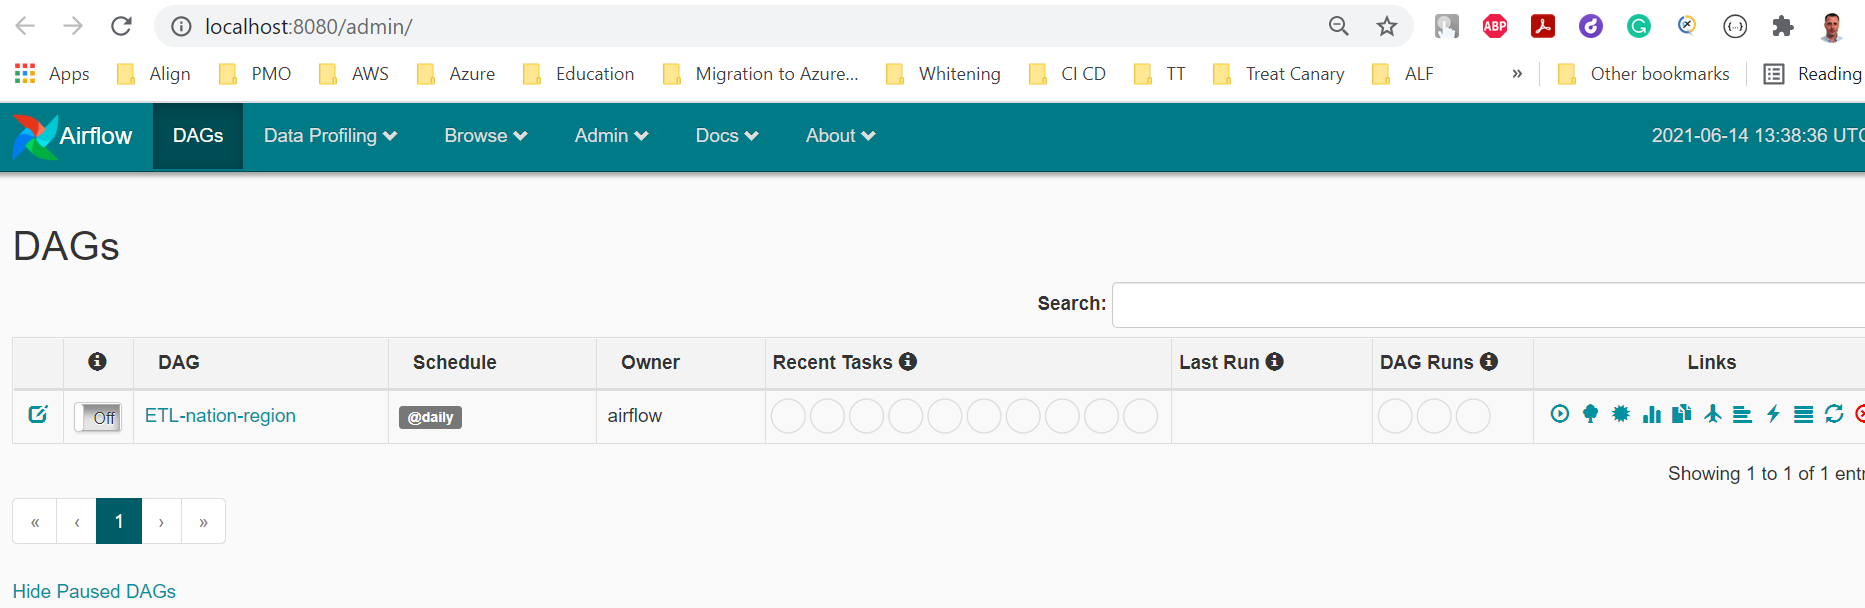

## 3.2. DAG dag_nation_region запущен (Graph View)
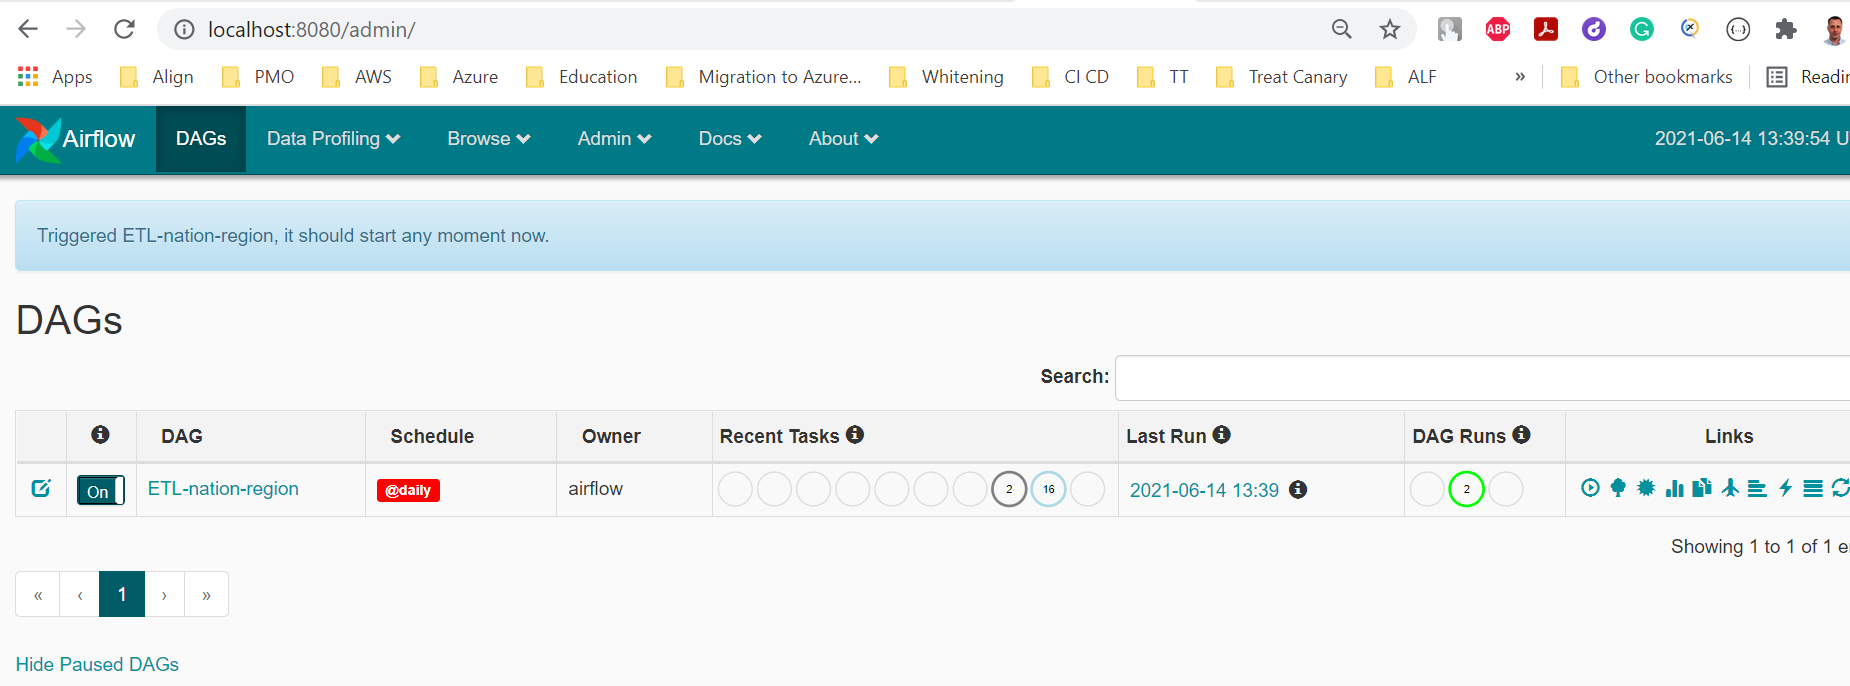

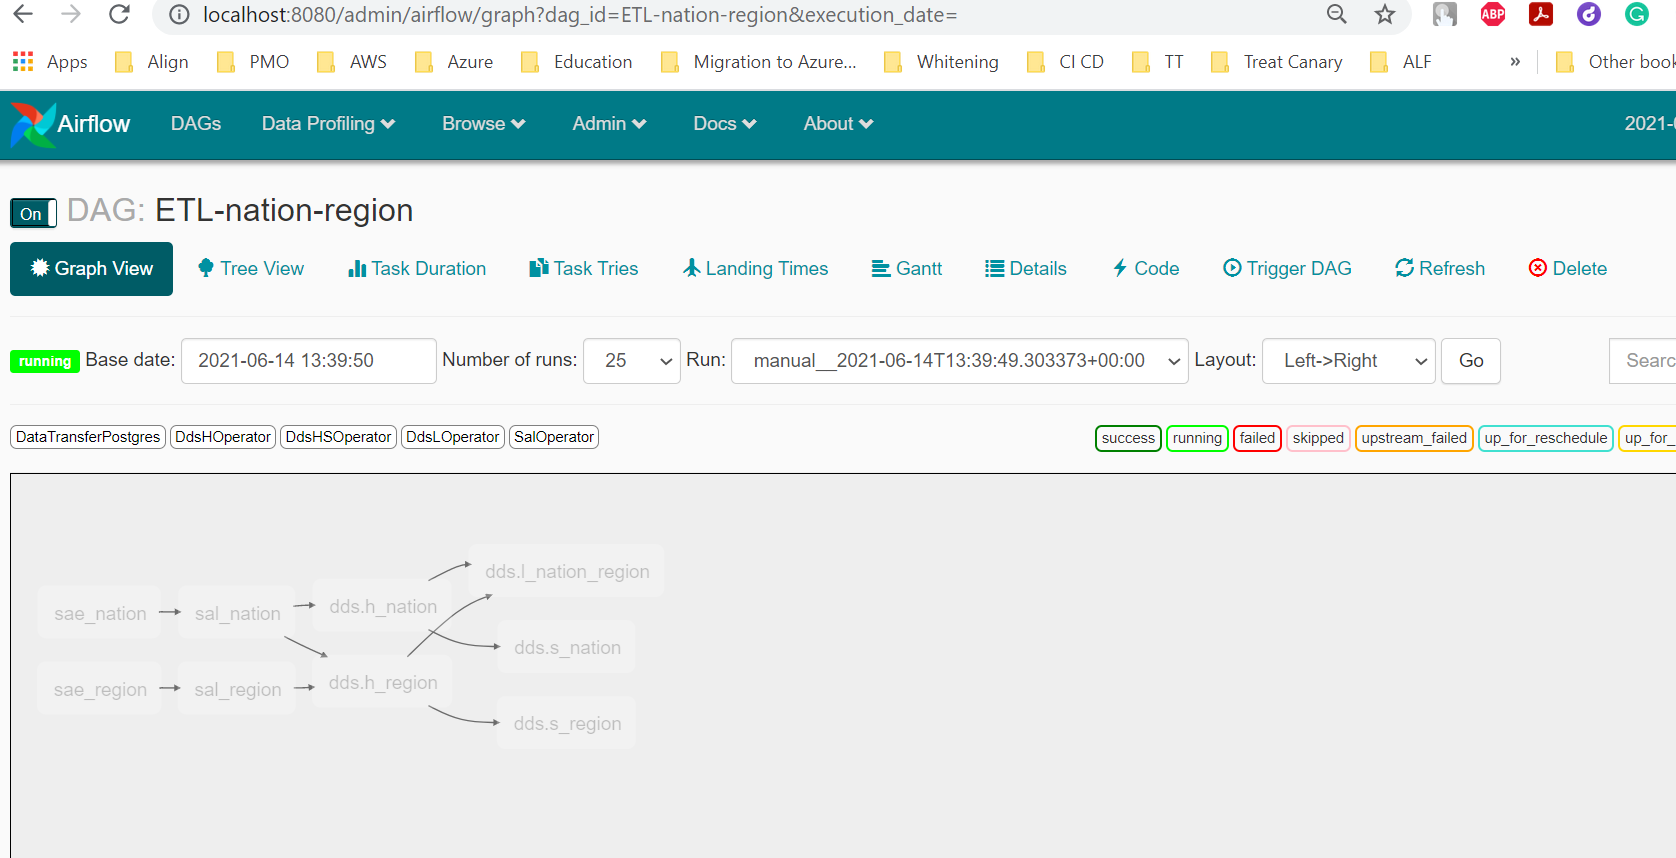

## 3.3. DAG dag_nation_region в работе #1
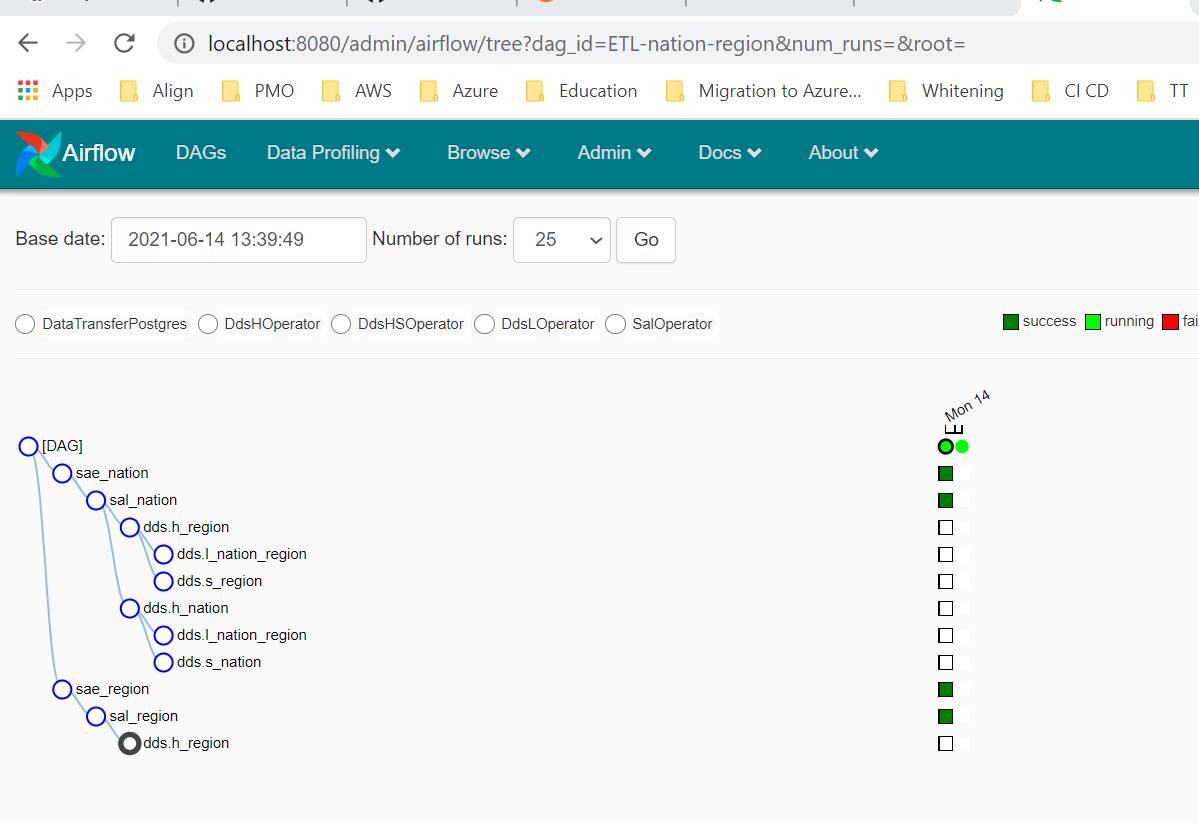

## 3.4. DAG dag_nation_region в работе #2
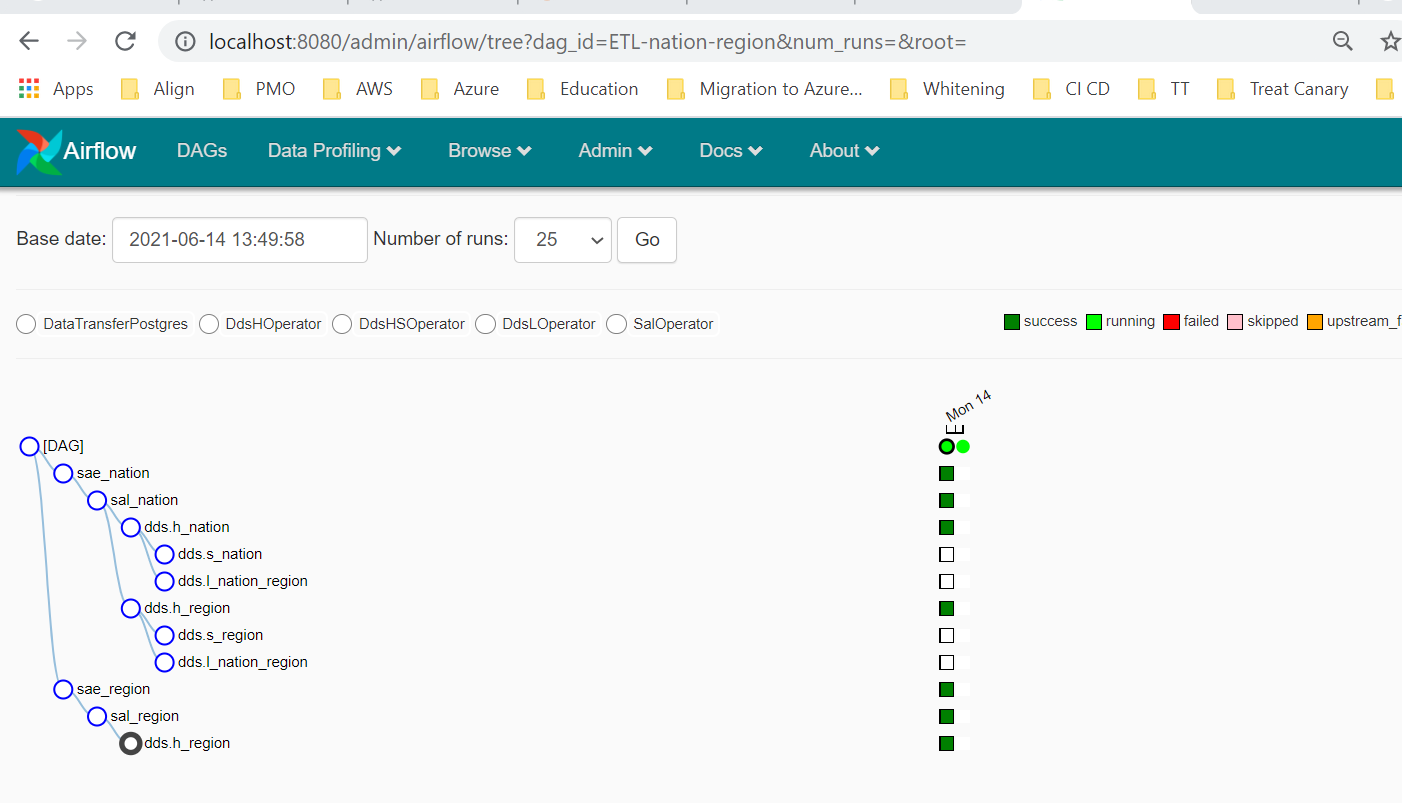

## 3.5. DAG dag_nation_region завершён успешно
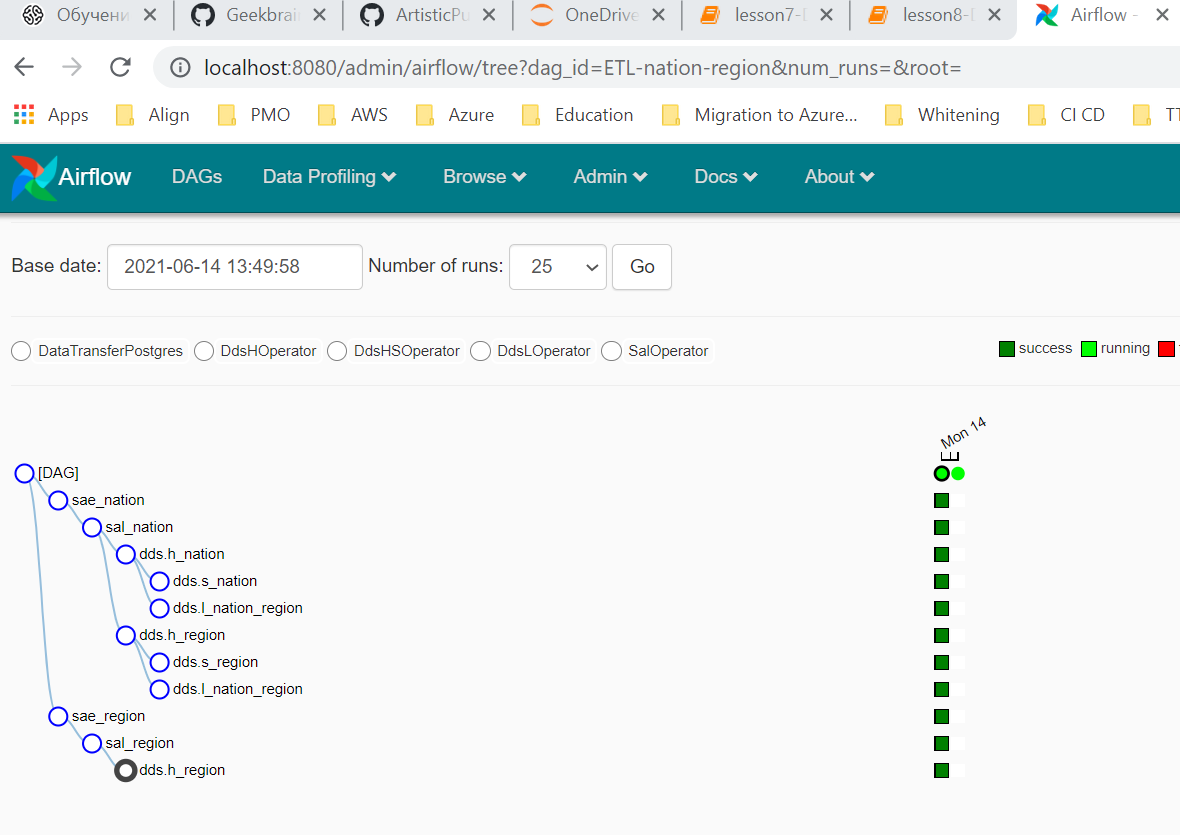

## 3.6. Исходная таблица src.nation
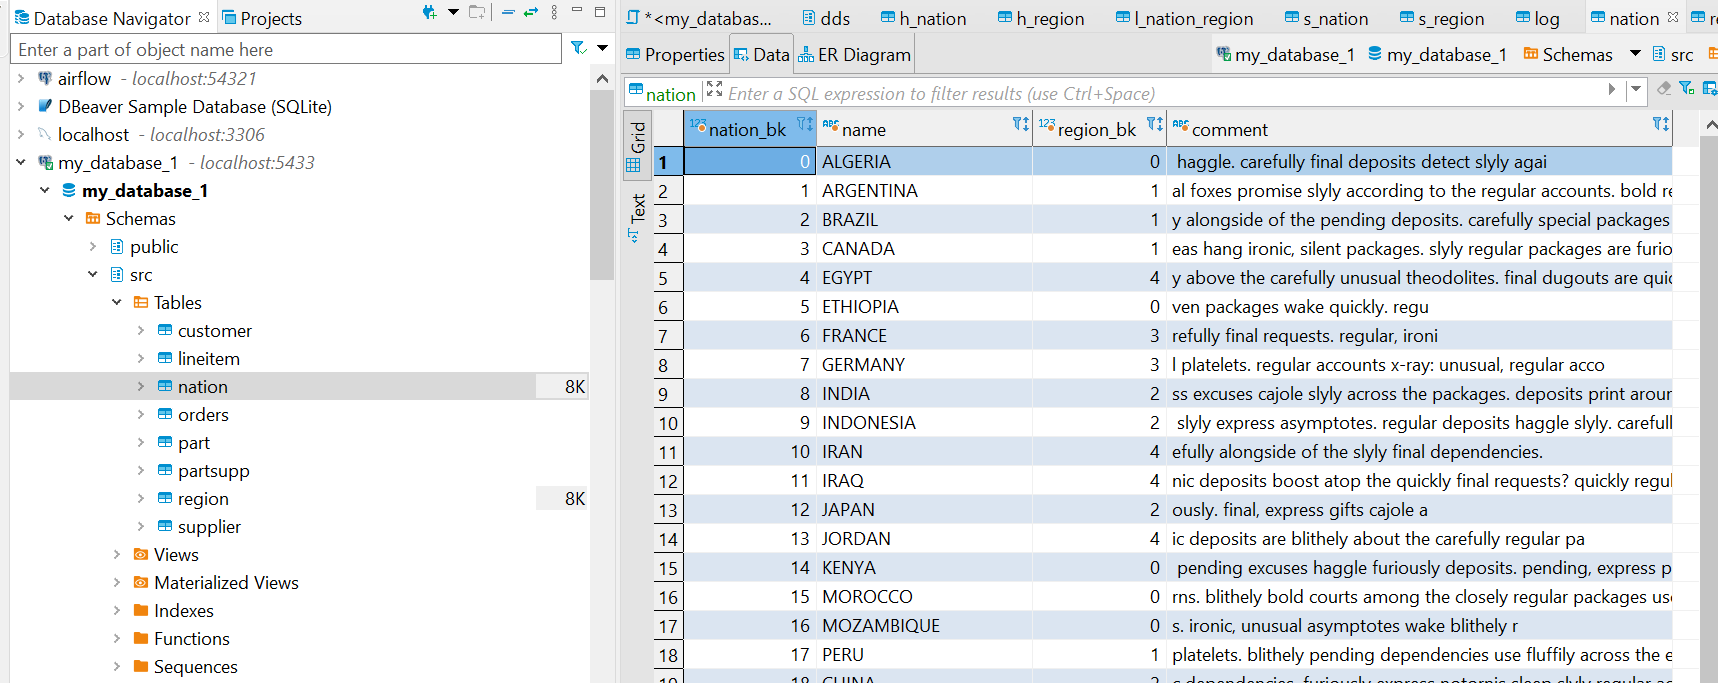

## 3.7. Исходная таблица src.region
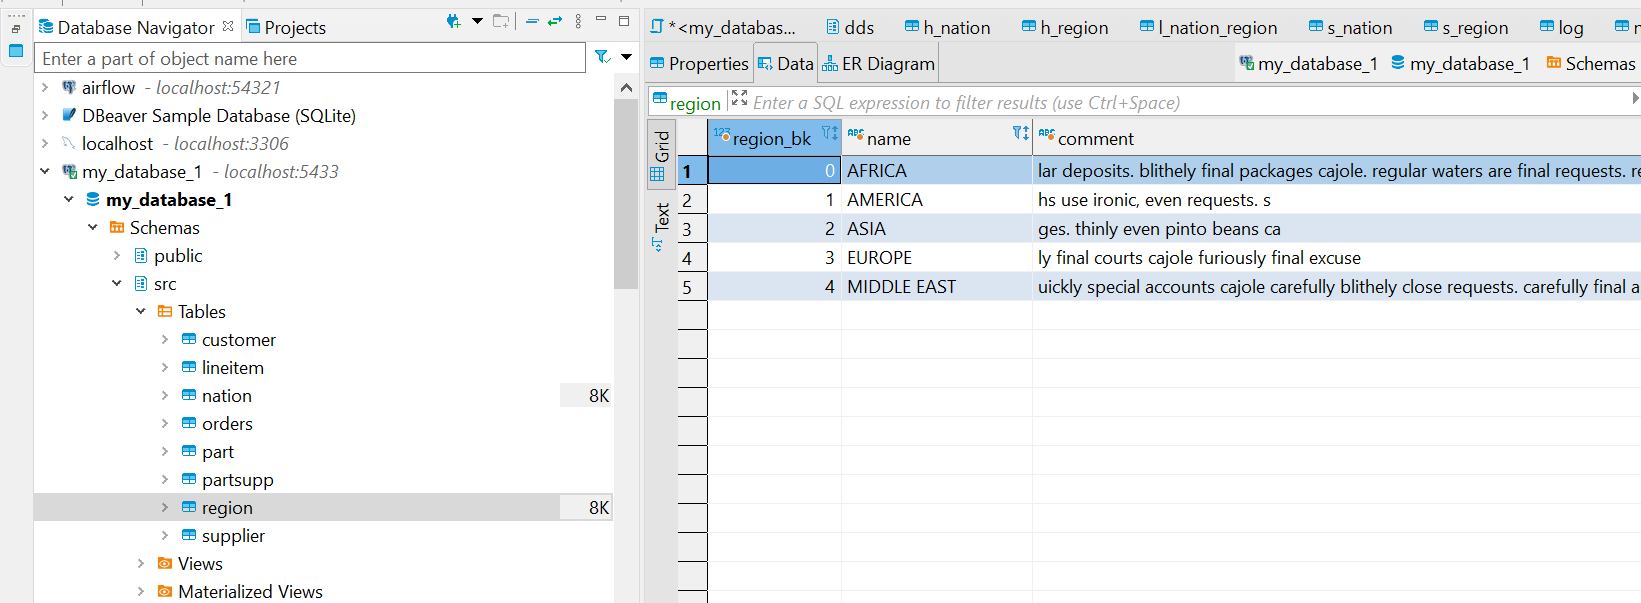

## 3.8. Целевая таблица h_nation
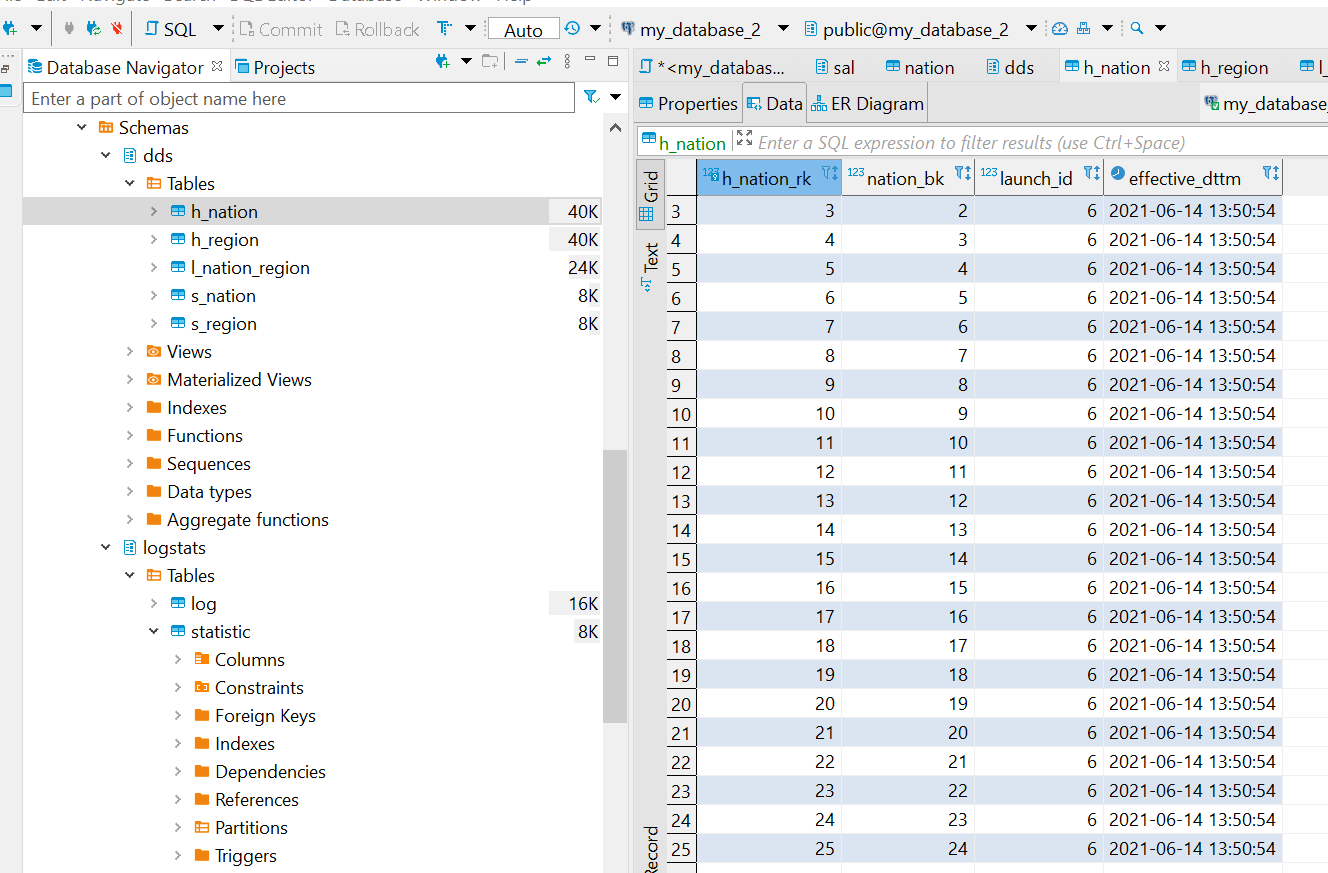

## 3.9. Целевая таблица h_region
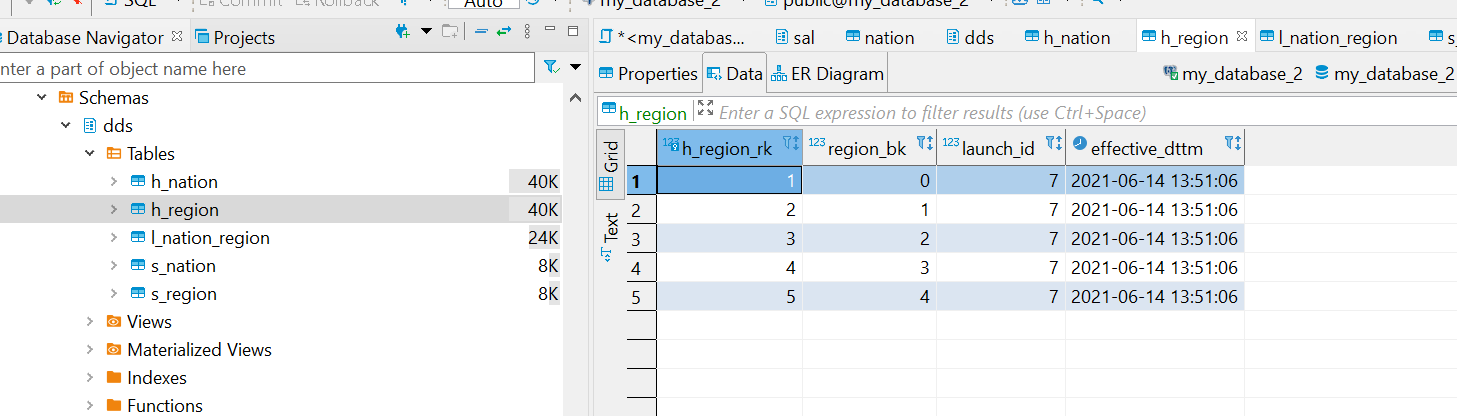

## 3.10. Таблица l_nation_region
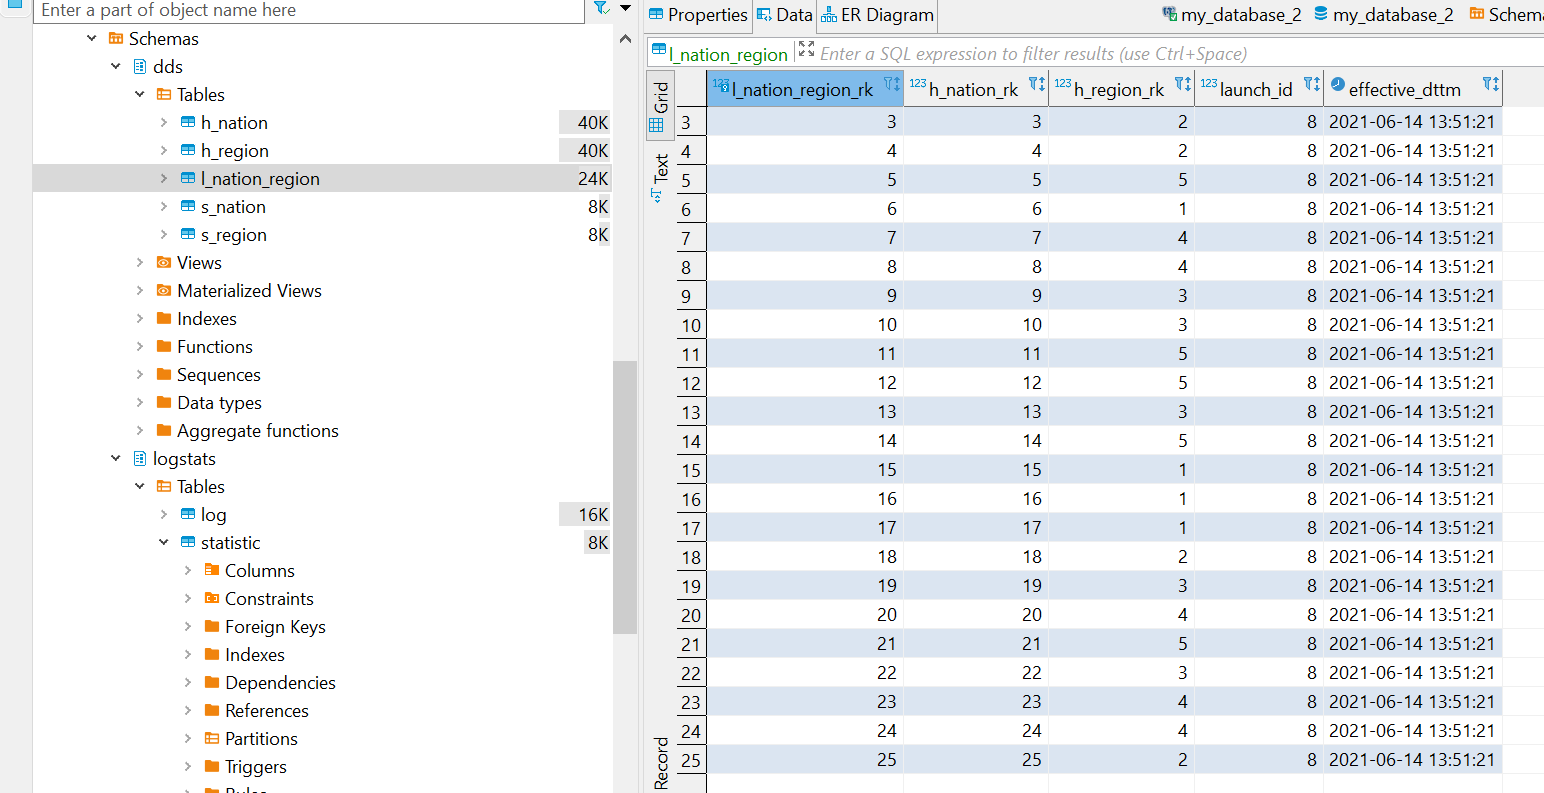

## 3.11. Целевая таблица s_nation
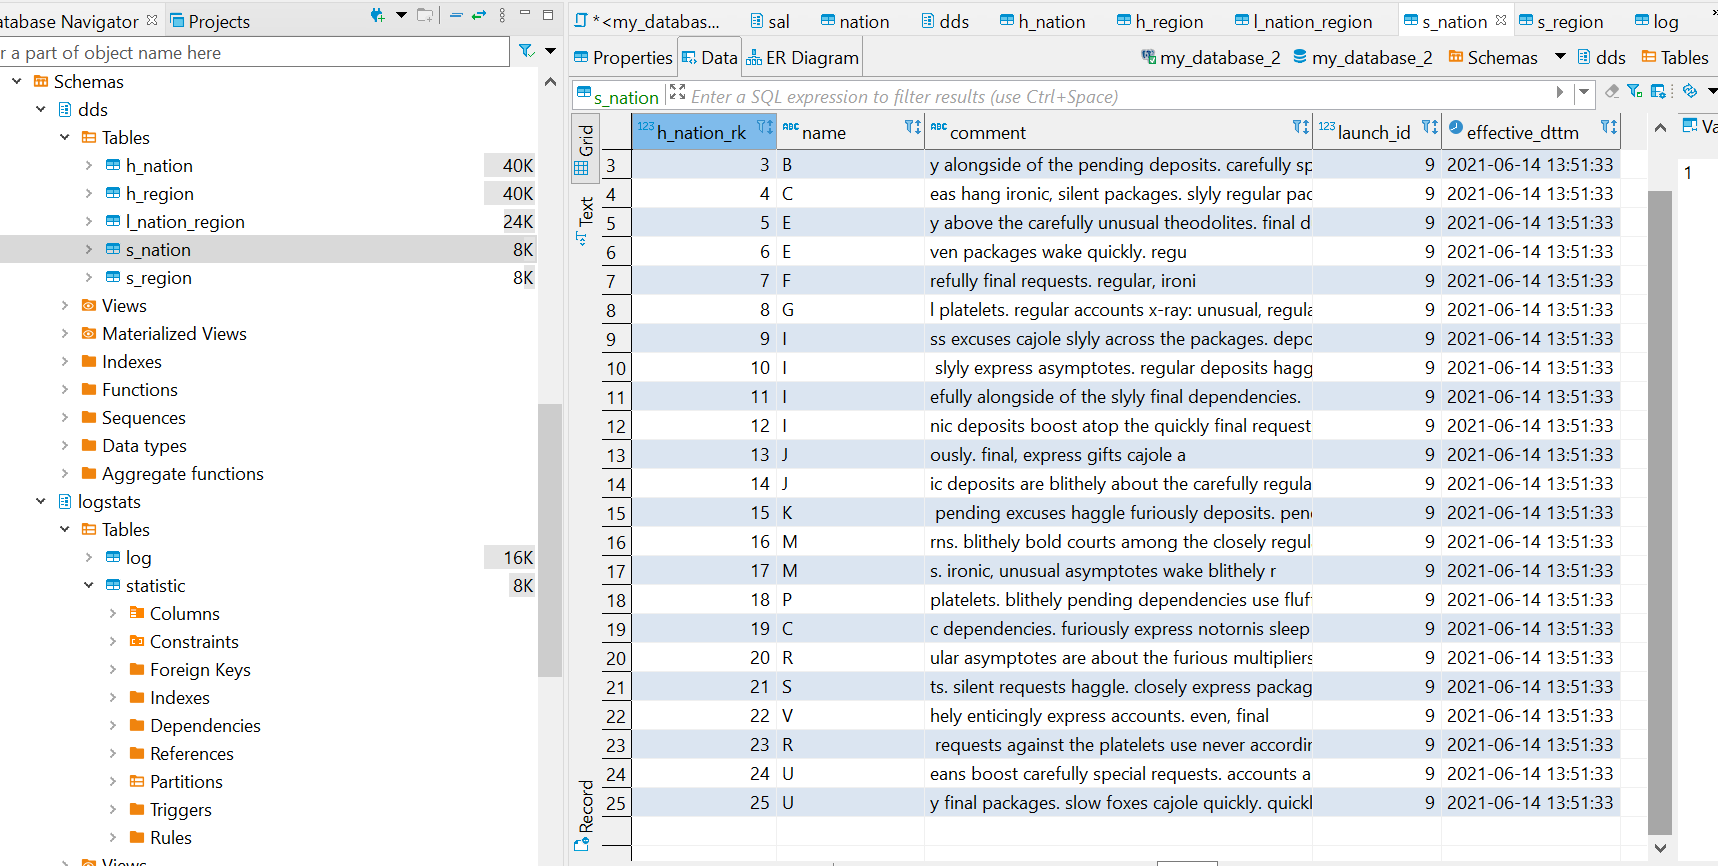

## 3.12. Целевая таблица s_region
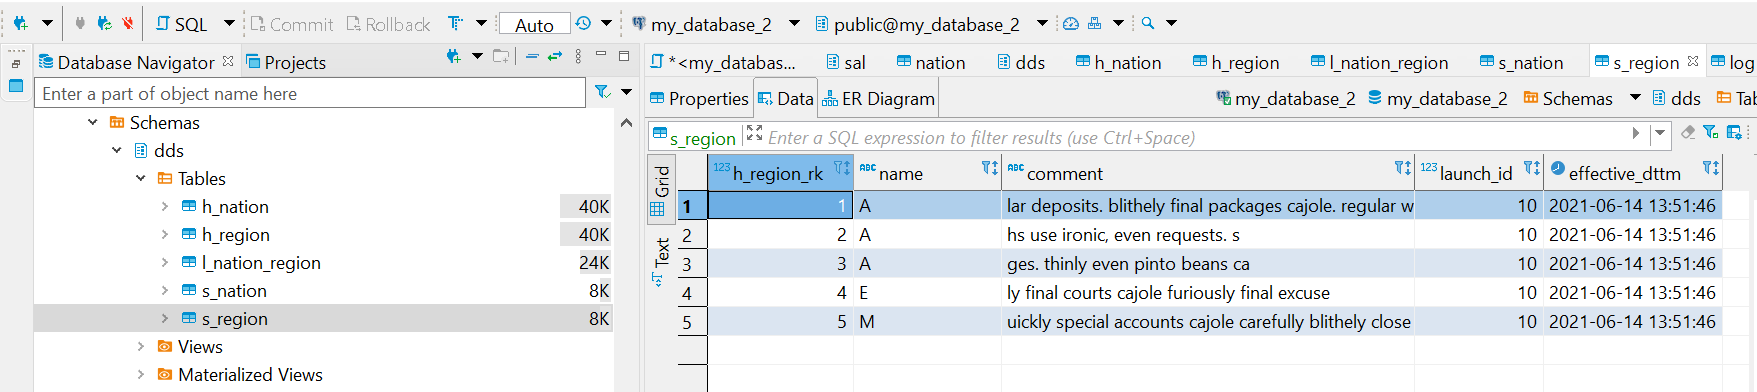

## 3.13. Внутренняя таблица log
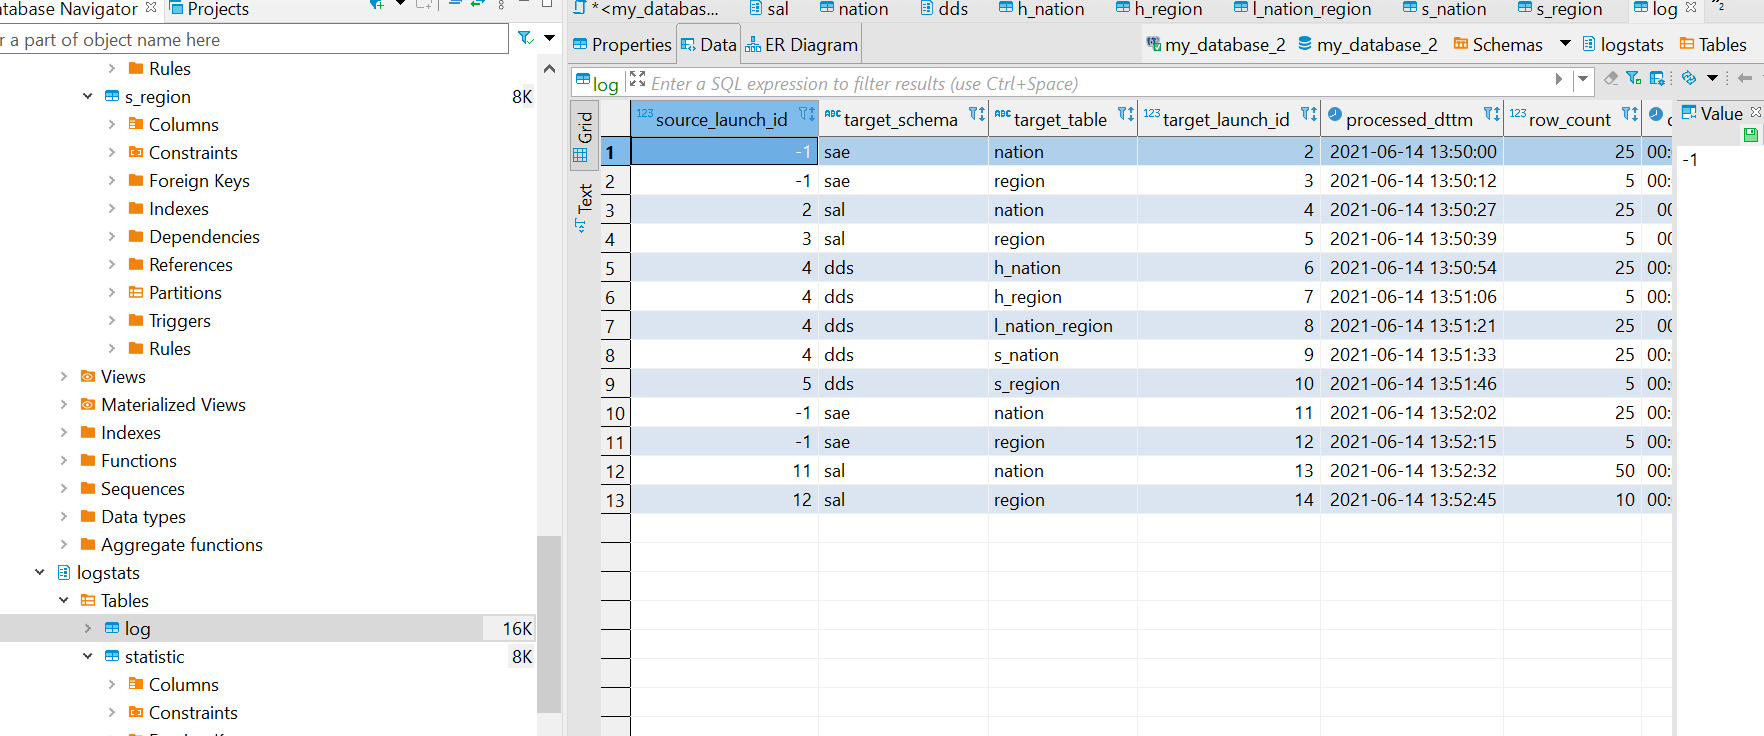